### This python notebook complements the report document (Capstone Report by SBaek.docx) and shows data analysis and calculation following the same numeric order of document sections

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import renders as rs

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\seungjinb\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Project roadmap (old)
1. Loading data/clean up
2. Dimensional Reduction (Principal Component Analysis)
3. Clustering Analysis
4. Classification model using Decision Tree
5. Model prediction for unknown dataset

# Project roadmap
1. Definition
2. Analysis
3. Methodology
4. Results
5. Conclusion

----

# Section 1. Definition

Please see the report document for the project overview and problem statement. 

# Section 2. Analysis

## Data Exploration

### 1-1. Import data/data clean up

* Among 10 features (except id number), I have decided perform feature selection where all the ratings informations were removed and time_on_site and listing features were combined as 'listing_per_day'
* Since some users began to sell on the first day they install the app, 'time_on_site' can be zero when there are number of listings recorded. In these cases, listing/time_on_site will generate 'Inf.' In order to avoid Inf happening, I have added 1 to all entries of 'time_on_site.' 

In [2]:
input_file = "data/Customer_activity.csv"
df = pd.read_csv(input_file, header = 0)
df2 = df.drop('install_date',axis=1)

# Create 'listing per day' data column
df2['listing_per_day'] = 0
df2['listing_per_day'][df2['time_on_site']>0] = df2['listing'][df2['time_on_site']>0]/(df2['time_on_site'][df2['time_on_site']>0])

C:\Users\seungjinb\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# see all features
df2.head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day
0,100000126,27,0,0,0,0,0,0,0,0,0.000000
1,100000329,5,0,0,0,0,0,0,0,0,0.000000
2,100002348,76,1,0,0,1,10,1,1,10,0.013158
3,100002548,5,0,0,0,40,357,0,0,0,8.000000
4,100003707,23,0,0,0,0,0,0,0,0,0.000000


### 1-2. Separate users with no selling item
* This users are assumed to be 'New seller' without much analysis or they could be just new users or simply be buyers.
* Only a small fraction of total users have items on sale

In [4]:
dfa = df2[df2['listing']>0]  # data active
dfi = df2[df2['listing']==0] # data inactive

print "* Only %.2f%% of the listed users has items on sale!" % (float(len(dfa))/float(len(df2))*100)
print "* => %.0f users out of total %.0f users have sold at least one item using the app." \
% (float(len(dfa)), float(len(df2)))

* Only 8.07% of the listed users has items on sale!
* => 97423 users out of total 1207774 users have sold at least one item using the app.


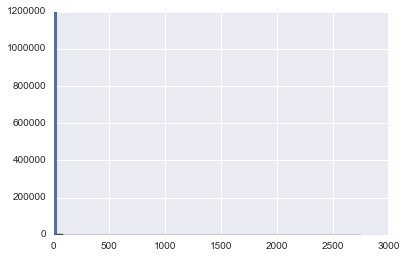

In [5]:
df2['listing'].hist(bins = 100)

# This is useless!!

### 1-3. Basic statistics of the active users (8.07% of total sellers)
* distributions of the sellers by using 'sale' or 'listing'

* use seaborn for faceted histograms

In [6]:
# dfa: active user data
dfa.head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day
2,100002348,76,1,0,0,1,10,1,1,10,0.013158
3,100002548,5,0,0,0,40,357,0,0,0,8.000000
25,100022372,26,0,0,0,9,250,0,0,0,0.346154
27,100023493,2,0,0,0,2,50,0,0,0,1.000000
42,100033232,57,0,0,0,9,143,1,1,25,0.157895


In [7]:
dfa[['time_on_site','listing']].head()

,time_on_site,listing
2,76,1
3,5,40
25,26,9
27,2,2
42,57,9


In [8]:
## dff : data frame final - datasets after feature selection

dff = dfa.iloc[:,[2,3,4,6,7,8,9,10]]

In [9]:
dff['listing_per_day'].describe()

count    97423.000000
mean         0.468860
std          1.504483
min          0.000000
25%          0.037037
50%          0.111111
75%          0.375000
max         89.111111
Name: listing_per_day, dtype: float64

## sort sellers with ratings higher, lower etc.

### compare revenue from users with ratings (pos, neu, neg) and no ratings

### * users with non-zero rating

In [10]:
df_rating= dff[(dff[['positive_rating','neutral_rating','negative_rating']]>0).any(1)]

### * users with non-zero rating

In [11]:
df_NOrating= dff[(dff[['positive_rating','neutral_rating','negative_rating']]==0).all(1)]

##### sanity check for users with/without ratings

In [12]:
len(df_rating)+len(df_NOrating)

97423

-------------------

In [13]:
dtemp = dfa.listing
dtemp2 = dfa.listing[dfa.listing < 100]

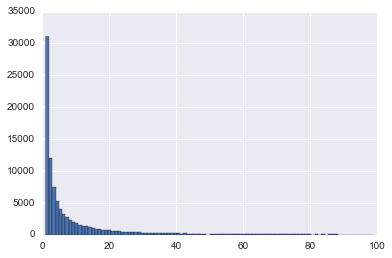

In [14]:
# listing 이 100 보다 작은 유저들의 히스토그램

#n, bins, patches = plt.hist(df_active.listing[df_active.listing<100],100)
#plt.hist()
#n, bins, patches = plt.hist(qq,100)
dfa['listing'][dfa['listing']<100].hist(bins = 100)

### Most of the sellers are the ones with number of selling items less than 20 or maybe 5. This is very skewed data. The revenue distribution, however, could be different from the number of listing.

C:\Users\seungjinb\Anaconda\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


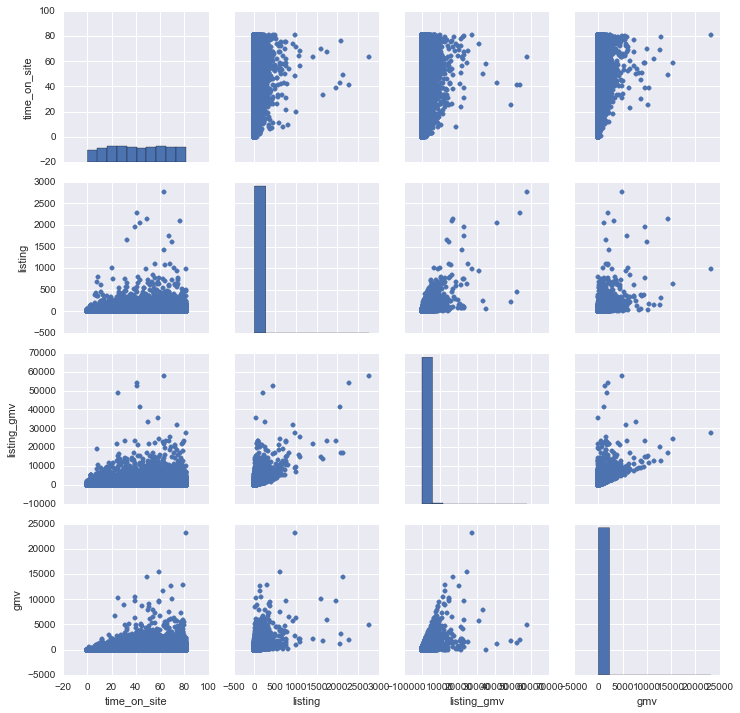

In [15]:
g = sns.PairGrid(dfa[['time_on_site','listing','listing_gmv','gmv']])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

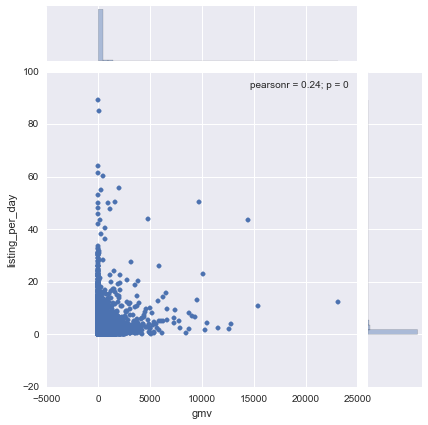

In [16]:
sns.jointplot(dff.gmv, dff.listing_per_day)

### Maybe apply log function to values and plot???

### 1-4. Further data clean-up
* Done in previous section: 'dff' is the final dataset to process

* Plot 'listing' vs 'sale'

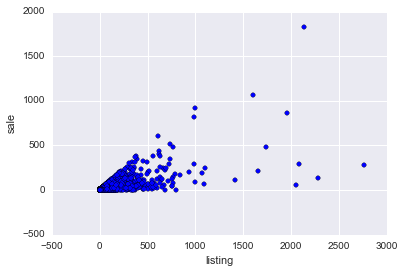

In [17]:
plt.scatter(dfa['listing'],dfa['sale'])
plt.xlabel('listing')
plt.ylabel('sale')

This is obvious, because sale # cannot exceed listing; all data points are shown below 45 degree line.

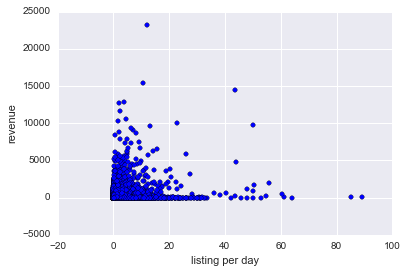

In [18]:
plt.scatter(dff['listing_per_day'],dfa['gmv'])
plt.xlabel('listing per day')
plt.ylabel('revenue')

When the revenue is compared with daily listing, clear correlation is hard to be seen.

> # 7/11/2016
> # Flash idea: using descision tree classifier to segregate sellers?

# 2. Dimensional Reduction
#### Original 11 features were reduced to 8 by feature selection, and
#### these 8 features reduced to ?? features

In [19]:
dff.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
2,1,0,0,10,1,1,10,0.013158
3,0,0,0,357,0,0,0,8.000000
25,0,0,0,250,0,0,0,0.346154
27,0,0,0,50,0,0,0,1.000000
42,0,0,0,143,1,1,25,0.157895


## 2-1. feature scaling
* Normalize each column before applying principal component analysis

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
dff.describe()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
count,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000
mean,2.387578,0.164581,0.036449,379.208462,2.699937,2.576353,67.179198,0.468860
std,11.463812,1.150350,0.366551,942.643014,13.607197,12.469444,278.430278,1.504483
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.037037
50%,0.000000,0.000000,0.000000,149.000000,0.000000,0.000000,0.000000,0.111111
75%,1.000000,0.000000,0.000000,375.000000,2.000000,2.000000,42.000000,0.375000
max,1430.000000,164.000000,57.000000,57706.000000,1826.000000,1595.000000,23175.000000,89.111111


In [22]:
scaler = MinMaxScaler()

# scaled data
dfs = pd.DataFrame(scaler.fit_transform(dff), columns = dff.columns)

# all columns are now 'scaled'
dfs.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
0,0.000699,0,0,0.000121,0.000548,0.000627,0.000431,0.000148
1,0.000000,0,0,0.006135,0.000000,0.000000,0.000000,0.089776
2,0.000000,0,0,0.004281,0.000000,0.000000,0.000000,0.003885
3,0.000000,0,0,0.000815,0.000000,0.000000,0.000000,0.011222
4,0.000000,0,0,0.002426,0.000548,0.000627,0.001079,0.001772


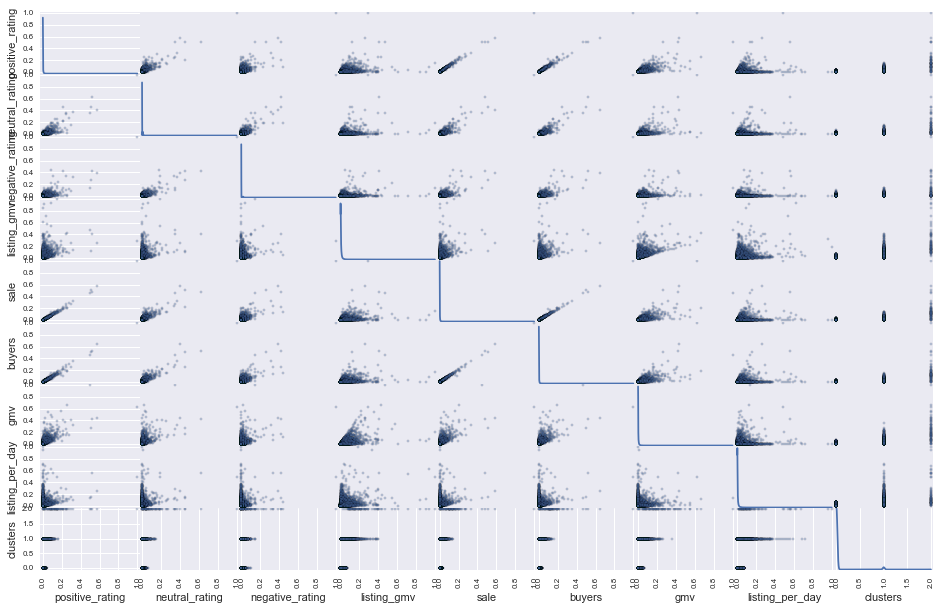

In [59]:
pd.scatter_matrix(dfs, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

## 2-2. PCA

### 2-2-1 include only a few features  (ratings NOT included)

> My initial thought was that most of the ratings are on positive side and only a few negative/neutral ones and therefore I removed all rating features.

In [23]:
from sklearn.decomposition import PCA
import renders as rs

pca = PCA().fit(dfs.iloc[:,3:])  # including columns ['listing_gmv' ~ 'listing_per_day']
print pca.explained_variance_ratio_

[  5.98187649e-01   2.36452149e-01   1.29020186e-01   3.61139428e-02
   2.26073134e-04]


### 2-2-2 include all features and let PCA handles the rest

> Ratings are added back in for PCA 

In [24]:
from sklearn.decomposition import PCA
pca_all = PCA().fit(dfs)  # including columns ['listing_gmv' ~ 'listing_per_day']
print pca_all.explained_variance_ratio_

[  5.67652802e-01   2.14000204e-01   1.44869071e-01   4.58475152e-02
   1.81139443e-02   9.07716579e-03   3.57220851e-04   8.20768457e-05]


### Based on the PCA (using all features), top three dimensions were selected and the feature dimension is now reduced to 3.

In [25]:
dfs.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
0,0.000699,0,0,0.000121,0.000548,0.000627,0.000431,0.000148
1,0.000000,0,0,0.006135,0.000000,0.000000,0.000000,0.089776
2,0.000000,0,0,0.004281,0.000000,0.000000,0.000000,0.003885
3,0.000000,0,0,0.000815,0.000000,0.000000,0.000000,0.011222
4,0.000000,0,0,0.002426,0.000548,0.000627,0.001079,0.001772


## Testing PCA with same number of original features (8 features)

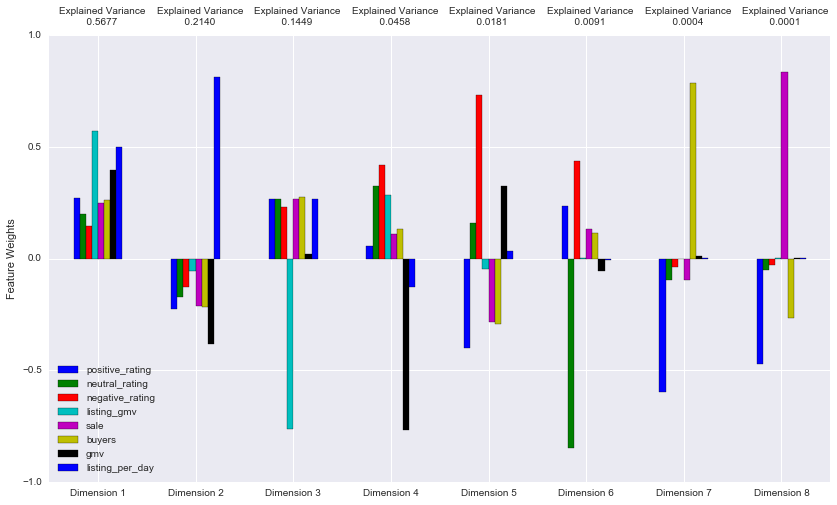

In [26]:
pca8 = PCA(n_components=8)
pca8.fit(dfs)  # dfs: scaled dff

reduced8 = pca8.transform(dfs)  # df_reduced: change variable names

#dfr8.shape
pca8_results = rs.pca_results(dfs,pca8)

## Must select first FIVE dimension to maintain 99% of all variances in data

In [27]:
pca5 = PCA(n_components=5).fit(dfs)
reduced5 = pca5.transform(dfs)  # df_reduced: change variable names

reduced5.shape

(97423L, 5L)

## Visualize feature distributions
To get a better understanding of the dataset, I construct a scatter matrix of each of the data features present in the data. 

In [28]:
# pd.scatter_matrix(dff, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

# - use 'normalized' dataset

# pd.scatter_matrix(dfs, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

# 3. Clustering Analysis

## 3-1. Assumption

#### I previously assumed that the sellers with no listing were categorized as 'new seller,' therefore the remaining 'active' sellers will need to be segmented into THREE groups.
1. Casual seller
2. Business seller
3. Top seller

> # 7/11/2016, 9/11/2016
> # For this project, we don't assume n = 3. Try multiple n and then compute silhouette coefficient value

> # And not just Kmeans clustering, but try other classifiers too.

#### After PCA, clustering analysis does not label the data, but rather segregates into group (in this case, three) purely based on the data; it's up to a human modeler to label them later, meaningfully.

## 3-2. Clustering

### 3-2-1. K-means clustering

### with sample_size = 20000

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

input_data = reduced5

In [30]:
row_selections = np.random.randint(len(input_data),size=20000)

for n in range(2,6):
    startT = time.time()
    
    # Clustering is being done with entire datasets, but silhouette score computation is NOT.

    clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500, 
                       random_state= 200)
    
    clusterer.fit(reduced5)
    cluster_labels = clusterer.fit_predict(input_data)
    
    
    startT = time.time()
    silhouette_avg = silhouette_score(input_data[row_selections,:],
                                  cluster_labels[row_selections])
    sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                              cluster_labels[row_selections])
    endT = time.time()
    print 'numer of clustering is',n,': silhouette score is',silhouette_avg
    print "elapsed time %.2f" % (endT-startT)

numer of clustering is 2 : silhouette score is 0.895474368978
elapsed time 114.40
numer of clustering is 3 : silhouette score is 0.851316633341
elapsed time 117.89
numer of clustering is 4 : silhouette score is 0.833795162921
elapsed time 121.22
numer of clustering is 5 : silhouette score is 0.759716759741
elapsed time 124.02


> below can be skipped

In [31]:
row_selections = np.random.randint(len(input_data),size=20000)

for n in range(2,6):
    # del cluster_labels, clusterer, silhouette_avg
    
    startT = time.time()

    clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500, 
                       random_state= 200)
    
    clusterer.fit(reduced5)
    #cluster_labels = clusterer.fit_predict(input_data)
    cluster_labels = clusterer.labels_
    
    startT = time.time()
    silhouette_avg = silhouette_score(input_data[row_selections,:],
                                  cluster_labels[row_selections])
    sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                              cluster_labels[row_selections])
    endT = time.time()
    print 'numer of clustering is',n,': silhouette score is',silhouette_avg
    print "elapsed time %.2f" % (endT-startT)

numer of clustering is 2 : silhouette score is 0.903753164306
elapsed time 119.67
numer of clustering is 3 : silhouette score is 0.857492754736
elapsed time 121.52
numer of clustering is 4 : silhouette score is 0.839071514725
elapsed time 135.54
numer of clustering is 5 : silhouette score is 0.76410845898
elapsed time 127.10


## TESTING plot when n = 3

In [31]:
input_data = reduced5
row_selections = np.random.randint(len(input_data),size=30000)

# number of clusters
n = 3

startT = time.time()

clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500)

clusterer.fit(reduced5)
#cluster_labels = clusterer.fit_predict(input_data)
cluster_labels = clusterer.labels_

In [30]:
silhouette_avg = silhouette_score(input_data[row_selections,:],
                              cluster_labels[row_selections])
sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                          cluster_labels[row_selections])
endT = time.time()
print 'numer of clustering is',n,': silhouette score is',silhouette_avg
print "elapsed time %.2f" % (endT-startT)

numer of clustering is 3 : silhouette score is 0.855088170985
elapsed time 961.18


> below can be skipped

In [31]:
input_data = reduced5
row_selections = np.random.randint(len(input_data),size=40000)

# number of clusters
n = 3

clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500, 
                   random_state= 200)

clusterer.fit(reduced5)
cluster_labels = clusterer.fit_predict(input_data)

startT = time.time()
silhouette_avg = silhouette_score(input_data[row_selections,:],
                              cluster_labels[row_selections])
sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                          cluster_labels[row_selections])
endT = time.time()
print 'numer of clustering is',n,': silhouette score is',silhouette_avg
print "elapsed time %.2f" % (endT-startT)

numer of clustering is 3 : silhouette score is 0.856467374834
elapsed time 2795.36


## Visualizing silhouette scores

29004
22
974


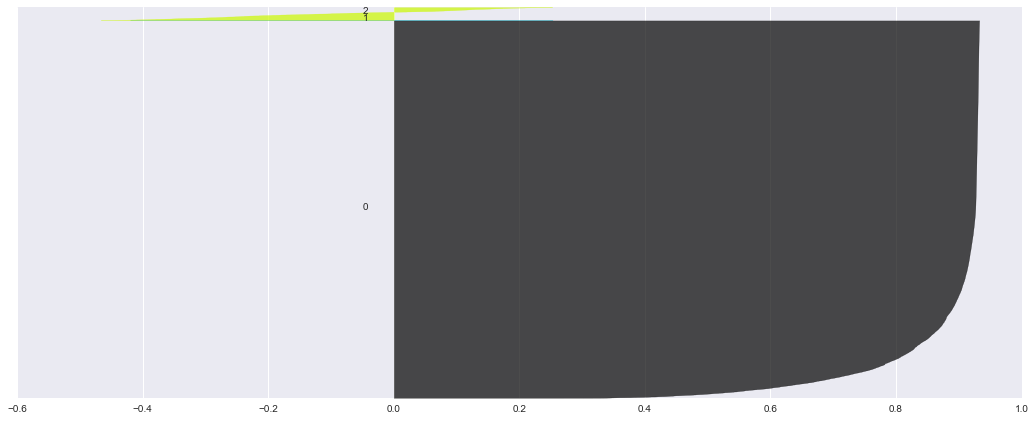

In [31]:
y_lower = 10
nn_cluster = 3

#fig, (ax1,ax2) = plt.subplots(1,2)
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,7)

# for i in range(1,nn_cluster):
for i in range(0,nn_cluster):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels[row_selections] == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.spectral(float(i)/nn_cluster)
    ax1.fill_betweenx(np.arange(y_lower,y_upper), 0,
                     ith_cluster_silhouette_values,
                     facecolor = color, edgecolor = color, alpha = 0.7)
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10
    ax1.set_yticks([])
    print size_cluster_i

Append the cluster groups to the database and examine each clusters

In [32]:
# dfs : scaled data
dfs['clusters'] = cluster_labels

# dfa: original 'active' data
dfa['clusters'] = cluster_labels

C:\Users\seungjinb\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
dfa[dfa['clusters'] == 1].head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day,clusters
3,100002548,5,0,0,0,40,357,0,0,0,8.000000,1
160,100132264,65,19,1,0,93,2065,21,20,490,1.430769,1
242,100203484,79,27,1,0,105,2477,29,29,754,1.329114,1
1232,100921416,60,22,2,0,108,1728,27,27,408,1.800000,1
1242,100924949,66,34,3,0,478,3958,38,38,398,7.242424,1


In [34]:
dfa[dfa['clusters'] == 2].head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day,clusters
4558,103409199,65,162,7,1,249,8466,174,155,5553,3.830769,2
7163,105352411,52,190,6,1,501,7416,203,181,3023,9.634615,2
23665,117759762,69,79,6,0,145,20190,85,76,12650,2.101449,2
27055,120319354,78,186,10,5,515,11171,209,199,4443,6.602564,2
33949,125512323,63,209,6,1,334,8935,220,183,4773,5.301587,2


In [47]:
dfa[dfa['clusters'] == 0].tail()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day,clusters
1207710,999942243,6,0,0,0,1,90,0,0,0,0.166667,0
1207735,999963328,20,3,1,0,12,205,4,4,18,0.600000,0
1207748,999974669,5,0,0,0,1,10,0,0,0,0.200000,0
1207751,999976784,8,1,0,0,9,655,1,1,80,1.125000,0
1207756,999981906,28,0,0,0,3,416,0,0,0,0.107143,0


In [48]:
# df2: original import without install_date column
# del df_clustered
df_clustered = pd.merge(df2, dfa[['id','clusters']],on='id',how='left')
df_clustered2 = df_clustered.fillna(3)

In [49]:
df_clustered2.head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day,clusters
0,100000126,27,0,0,0,0,0,0,0,0,0.000000,3
1,100000329,5,0,0,0,0,0,0,0,0,0.000000,3
2,100002348,76,1,0,0,1,10,1,1,10,0.013158,0
3,100002548,5,0,0,0,40,357,0,0,0,8.000000,1
4,100003707,23,0,0,0,0,0,0,0,0,0.000000,3


In [50]:
df_kmeans = df_clustered2.groupby(df_clustered2['clusters'])

In [51]:
df_kmeans[['listing','listing_gmv','sale','buyers','gmv']].describe()

listing     listing_gmv            sale  \
clusters                                                         
0        count    93915.000000    93915.000000    93915.000000   
         mean         8.733887      273.256338        1.607475   
         std         14.286154      374.521167        3.850320   
         min          1.000000        3.000000        0.000000   
         25%          1.000000       50.000000        0.000000   
         50%          3.000000      138.000000        0.000000   
         75%         10.000000      340.000000        1.000000   
         max        225.000000     4000.000000       60.000000   
1        count     3431.000000     3431.000000     3431.000000   
         mean       104.140192     2945.037015       26.652579   
         std         89.107138     2521.002412       31.667652   
         min          1.000000       50.000000        0.000000   
         25%         44.000000     1387.500000        4.000000   
         50%         83.000000     2331.000000       17.000000   
         75%        137.000000     3730.000000       38.000000   
         max        769.000000    23093.000000      255.000000   
2        count       77.000000       77.000000       77.000000   
         mean       691.649351    15277.077922      267.857143   
         std        578.994791    11955.298952      274.148045   
         min         39.000000     1547.000000        0.000000   
         25%        311.000000     7535.000000      119.000000   
         50%        555.000000    11595.000000      209.000000   
         75%        802.000000    18981.000000      314.000000   
         max       2758.000000    57706.000000     1826.000000   
3        count  1110351.000000  1110351.000000  1110351.000000   
         mean         0.000000        0.000000        0.000000   
         std          0.000000        0.000000        0.000000   
         min          0.000000        0.000000        0.000000   
         25%          0.000000        0.000000        0.000000   
         50%          0.000000        0.000000        0.000000   
         75%          0.000000        0.000000        0.000000   
         max          0.000000        0.000000        0.000000   

                        buyers             gmv  
clusters                                        
0        count    93915.000000    93915.000000  
         mean         1.560145       41.293734  
         std          3.691204       98.944109  
         min          0.000000        0.000000  
         25%          0.000000        0.000000  
         50%          0.000000        0.000000  
         75%          1.000000       35.000000  
         max         58.000000     1541.000000  
1        count     3431.000000     3431.000000  
         mean        25.019528      658.105800  
         std         29.403435      764.350098  
         min          0.000000        0.000000  
         25%          4.000000      110.000000  
         50%         16.000000      439.000000  
         75%         36.000000      924.000000  
         max        248.000000     8446.000000  
2        count       77.000000       77.000000  
         mean       241.987013     5308.272727  
         std        247.732426     4060.448286  
         min          0.000000        0.000000  
         25%        103.000000     2653.000000  
         50%        187.000000     4443.000000  
         75%        301.000000     7325.000000  
         max       1595.000000    23175.000000  
3        count  1110351.000000  1110351.000000  
         mean         0.000000        0.000000  
         std          0.000000        0.000000  
         min          0.000000        0.000000  
         25%          0.000000        0.000000  
         50%          0.000000        0.000000  
         75%          0.000000        0.000000  
         max          0.000000        0.000000

### 3-2-2. DBSCAN clustering

As seen in the figure and number of users in each clusters, clusters are not evenly distributed and one or two clusters contain most of the datasets.

In the next subsection, I tried a different clustering algorighm of DBSCAN, which views clusters as areas of high density separated by areas of low density. It is known that the clusters found using DBSCAN can be any shape, whereas k-means assumes the clusters to be convex shapes. Having negative silhouette scores in may smaller clusters found using k-means may indicate that the ground truth clusters may not be convex shapes.

DBSCAN is known to be good for data which contains clusters of similar density.

There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster.

# DBSCAN crashes when processed with all of the data!!!

In [47]:
startT = time.time()
from sklearn.cluster import DBSCAN

row_selections = np.random.randint(len(input_data),size=40000)
db = DBSCAN(eps=0.5, min_samples = 30).fit(input_data[row_selections,:])
# db = DBSCAN(eps=0.5, min_samples = 30).fit(input_data)

endT = time.time()
print "elapsed time %.2f minutes" % ((endT-startT)/60.0)

elapsed time 3.27 minutes


In [50]:
startT = time.time()
from sklearn.cluster import DBSCAN

row_selections = np.random.randint(len(input_data),size=60000)
db = DBSCAN(eps=0.5, min_samples = 30).fit(input_data[row_selections,:])
# db = DBSCAN(eps=0.5, min_samples = 30).fit(input_data)

endT = time.time()
print "elapsed time %.2f minutes" % ((endT-startT)/60.0)

elapsed time 13.87 minutes


In [51]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [52]:
n_clusters_

1

In [53]:
len(db.labels_[db.labels_==0])

59998

In [54]:
len(db.labels_[db.labels_==-1])

2

> DBSCAN does not work well with the entire dataset

### 3-2-3. Hierarchical clustering

In [58]:
input_data.shape

(97423, 5)

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
startT = time.time()
row_selections = np.random.randint(len(input_data),size=20000)
model = AgglomerativeClustering(linkage = 'average',n_clusters = 3)
model.fit(input_data[row_selections,:])
endT = time.time()

print "elapsed time %.2f" % (endT-startT)

elapsed time 3503.71


In [43]:
set(model.labels_)

{0, 1, 2}

In [44]:
startT = time.time()
row_selections = np.random.randint(len(input_data),size=30000)
model = AgglomerativeClustering(linkage = 'average',n_clusters = 3)
model.fit(input_data[row_selections,:])
endT = time.time()

print "elapsed time %.2f" % (endT-startT)

elapsed time 11407.37


In [45]:
set(model.labels_)

{0, 1, 2}

#### silhouette score for Agg clustering

In [47]:

# number of clusters
n = 3

startT = time.time()

#clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500)

#clusterer.fit(reduced5)
#cluster_labels = clusterer.fit_predict(input_data)
#cluster_labels = clusterer.labels_
cluster_labels = model.labels_

silhouette_avg = silhouette_score(input_data[row_selections,:],
                              cluster_labels)
sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                          cluster_labels)
endT = time.time()
print 'numer of clustering is',n,': silhouette score is',silhouette_avg
print "elapsed time %.2f" % (endT-startT)

numer of clustering is 3 : silhouette score is 0.987138129943
elapsed time 836.37


29998
1
1


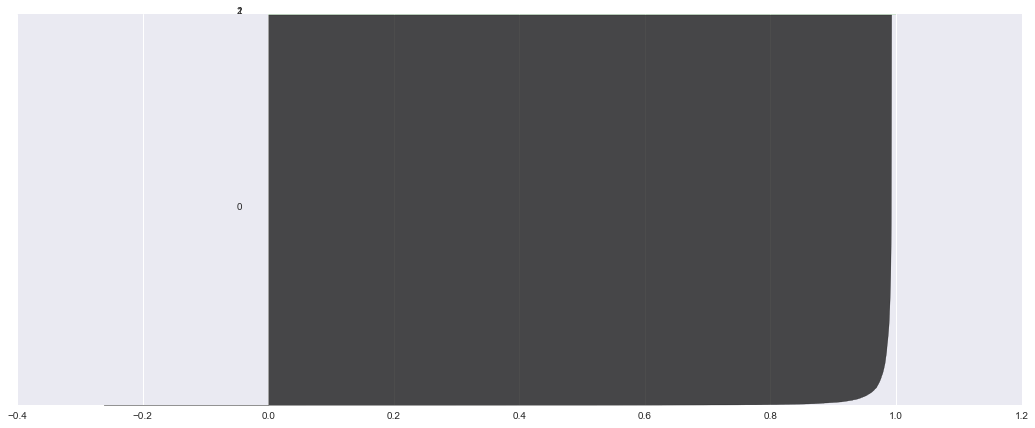

In [48]:
y_lower = 10
nn_cluster = 3

#fig, (ax1,ax2) = plt.subplots(1,2)
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,7)

# for i in range(1,nn_cluster):
for i in range(0,nn_cluster):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.spectral(float(i)/nn_cluster)
    ax1.fill_betweenx(np.arange(y_lower,y_upper), 0,
                     ith_cluster_silhouette_values,
                     facecolor = color, edgecolor = color, alpha = 0.7)
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10
    ax1.set_yticks([])
    print size_cluster_i

> AgglomerativeClustering takes long time!!

## 3-3. Data Labeling with group numbers

### Labeling based on average listings per each group

In [58]:
group_listing = df_clustered2['listing'].groupby(df_clustered2['clusters'])
group_listing.mean()


clusters
0      8.733887
1    104.140192
2    691.649351
3      0.000000
Name: listing, dtype: float64

### As shown above, the average listings per each labeled group were computed. It is now possible to determine which group belongs to which predefined seller groups.


* Group 0: casual seller (avg 8.7 listings)
* Group 1: business seller (avg 104.1 listings)
* Group 2: top seller (avg 691.6 listings)
* Group 3: new seller (none listed)

## 3-4. Export to csv file

In [61]:
df_clustered2.to_csv('All_data_clustered.csv')
df_clustered2[df_clustered2['clusters']==0].to_csv('data_casual_seller.csv')
df_clustered2[df_clustered2['clusters']==1].to_csv('data_business_seller.csv')
df_clustered2[df_clustered2['clusters']==2].to_csv('data_top_seller.csv')
df_clustered2[df_clustered2['clusters']==3].to_csv('data_new_seller.csv')


# Future recommendation

* Now the clustering the seller is done. 
* Based on the seller segregation done in the previous step, we may be able to predict which group a unknown seller belongs when features of the seller are known.
